# Descrição do Projeto

A empresa Sweet Lift Taxi coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora. 	
Construa um modelo para tal predição.

A métrica REQM no conjunto de teste não deve ser superior a 48.

## Instruções do projeto

1. Faça download dos dados e faça uma nova amostragem em uma hora.
2. Analise os dados
3. Treine diferentes modelos com diferentes hiperparâmetros. A amostra de teste deve ser 10% do conjunto de dados inicial.
4. Teste os dados usando a amostra de teste e forneça uma conclusão.

## Descrição dos dados

Os dados são armazenados no arquivo `taxi.csv`. O número de pedidos está na coluna `num_orders`.

## Preparação 

Primeiro passo será importar as bibliotecas necessárias.

In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.metrics
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from IPython.display import display
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV

Carreguei os dados me certificando que as data se tornem os índices da tabela, estejam em ordem crescente e que estão no formato correto. 

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [3]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Verifiquei que as datas e horas estão em ordem cronológica:

In [5]:
df.index.is_monotonic

True

Conforme solicitado, fiz a reamostragem com uma hora de diferença.

In [6]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Análise

Gráfico do número de ordens ao longo do tempo:

<AxesSubplot:xlabel='datetime'>

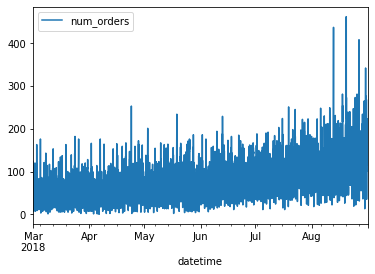

In [7]:
df.plot()

Gráfico da média móvel (tamanho da janela = 24) do número de ordens ao longo do tempo:

In [8]:
df['rolling_mean'] = df.rolling(24).mean()

<AxesSubplot:xlabel='datetime'>

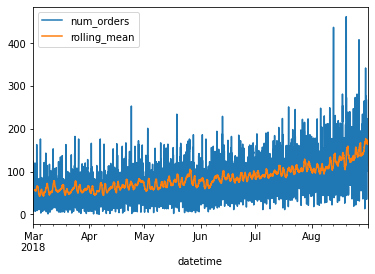

In [9]:
df.plot()

Aqui usei decomposed para estudar a tendencia, sazonalidade e resíduo da série. Estudei janelas diferentes dos dados. Na janela inteira, entre os meses de março e agosto de 2018, percebe-se uma tendencia de alta no número ordens. Não há sazonalidade entre os meses.   

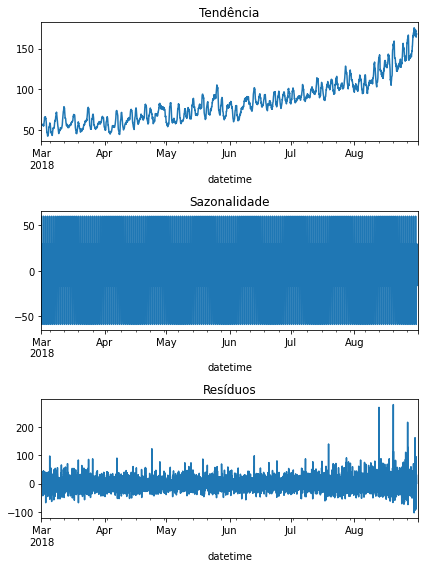

In [10]:
decomposed = seasonal_decompose(df['num_orders']) 

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')
plt.tight_layout()

Pegando duas janelas de 1 mês, nota-se que não há uma tendência bem definida e há sazonalidade quase que diariamente.  

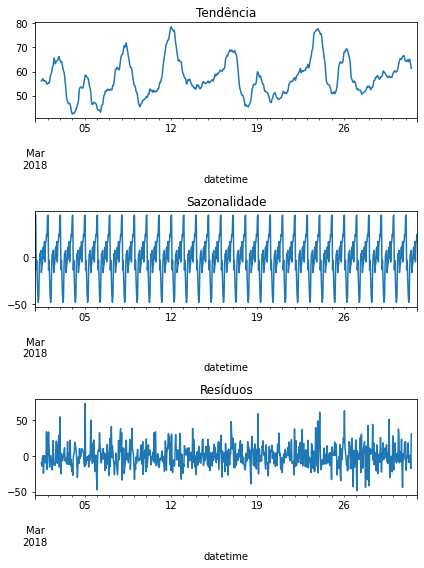

In [11]:
df_mar =df['num_orders']['2018-03']

decomposed = seasonal_decompose(df_mar) 

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')
plt.tight_layout()


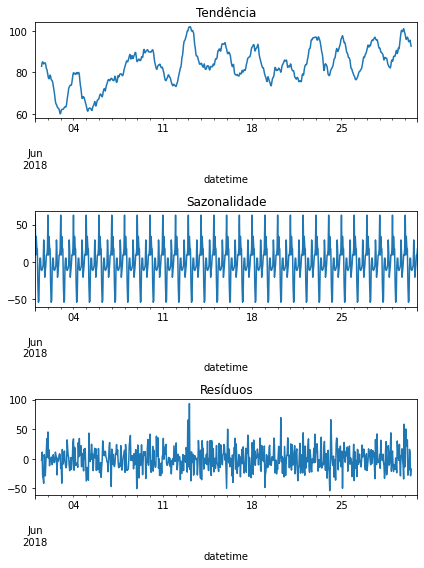

In [12]:
df_jun =df['num_orders']['2018-06']

decomposed = seasonal_decompose(df_jun) 

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')
plt.tight_layout()


Estudando duas janelas de 15 dias, nota-se que não há uma tendência de alta e baixa quase que periódica. Talvez, alguns dias da semana o número de ordens seja maior que outros. 

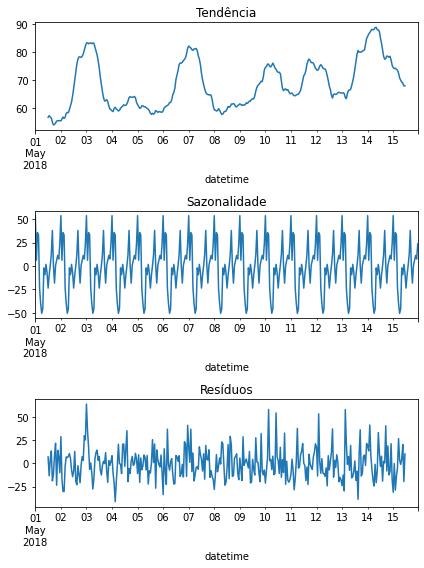

In [13]:
df_week1 =df['num_orders']['2018-05-01':'2018-05-15']

decomposed = seasonal_decompose(df_week1) 

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')
plt.tight_layout()

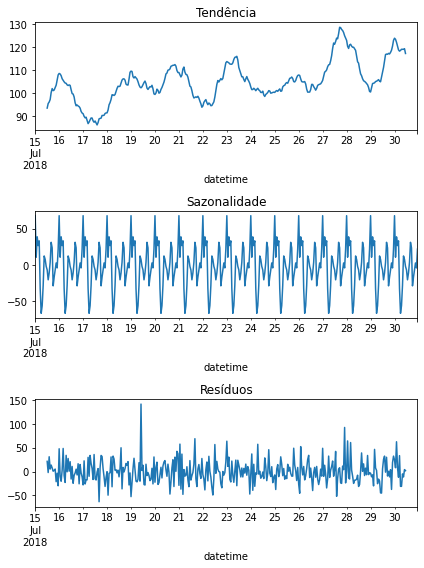

In [14]:
df_week2 =df['num_orders']['2018-07-15':'2018-07-30']

decomposed = seasonal_decompose(df_week2) 

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')
plt.tight_layout()

Estudando duas janelas de 2 dias, nota-se uma sazonalidade nos horários. Mais altos em torno da meia noite e mais baixos as 6h da manhã.

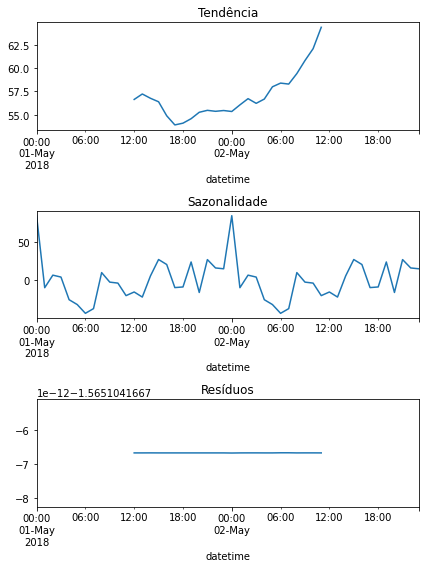

In [15]:
df_day1 =df['num_orders']['2018-05-01':'2018-05-02']

decomposed = seasonal_decompose(df_day1) 

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')
plt.tight_layout()



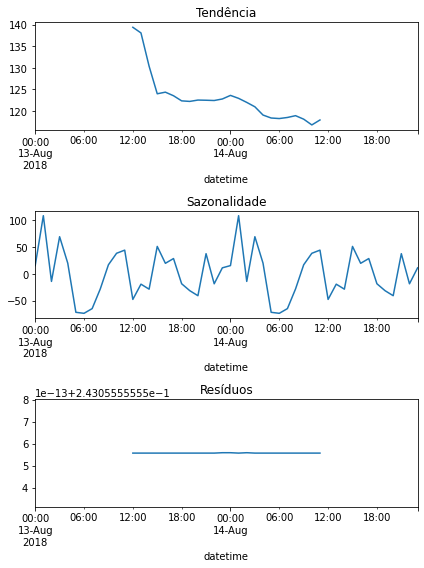

In [16]:
df_day2 =df['num_orders']['2018-08-13':'2018-08-14']

decomposed = seasonal_decompose(df_day2) 

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')
plt.tight_layout()



Analisarei a estacionariedade  da série. 

<AxesSubplot:xlabel='datetime'>

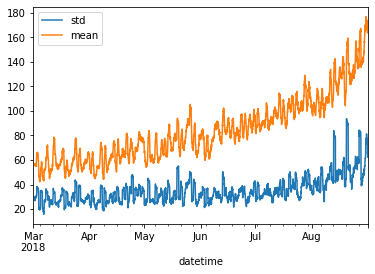

In [17]:
df['mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
df[['std','mean']].plot() 

Percebe-se que ela não é estacionária, pois tanto a média quanto a variância mudam ao longo do tempo.

Tentei tornar a série estacionária tomando a diferença de seus valores. 

<AxesSubplot:xlabel='datetime'>

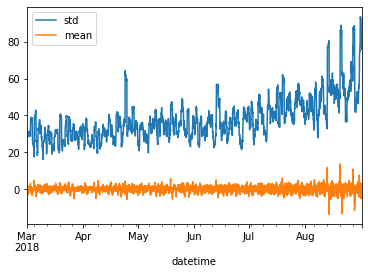

In [18]:
df_est = df - df.shift()
df_est = df_est.fillna(0)
df_est['mean'] = df_est['num_orders'].rolling(24).mean()
df_est['std'] = df_est['num_orders'].rolling(24).std()
df_est[['std','mean']].plot()

Entretanto, apesar da média não mudar, o desvio padrão continua se alternado. Logo, a série continua não estacionária.

## Treinamento

Comecei o treinamento dos modelos: 

In [19]:
df = df.drop(['rolling_mean','mean','std'],axis=1)
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Criei uma função para adicionar features a tabela. 

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    



In [21]:
make_features(df, 4, 12)

Abaixo o data frame com as features: ano, dia, mês, dia da semana, hora, lag e média móvel. Escolhi defasagem (lag) = 4 e janela = 12 para a média móvel. 

<div class="alert alert-block alert-success">
<b>Comentário da Revisora (revisão 1)</b> <a class="tocSkip"></a>
    
Sucesso!
</div>

In [22]:
df

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,19,207.0,217.0,197.0,116.0,163.416667
2018-08-31 20:00:00,154,2018,8,31,4,20,136.0,207.0,217.0,197.0,170.916667
2018-08-31 21:00:00,159,2018,8,31,4,21,154.0,136.0,207.0,217.0,168.583333


Dividi df em conjunto de teste, validação e treinamento.

In [23]:
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state= 12345)

train = train.dropna()

Dividi cada conjunto em features e target: 

In [24]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']


Tentei duas maneiras para prever a série temporal sem treinamento:

1) Todos os valores da amostra de teste são preditos com o a mediana do conjunto de treinamento. 

In [34]:
%%time
pred_median = np.ones(test.shape[0]) * train['num_orders'].median()
reqm_med = mean_squared_error(target_test, pred_median)**0.5
print('REQM:', reqm_med)

REQM: 87.15277582981295
CPU times: user 0 ns, sys: 4.35 ms, total: 4.35 ms
Wall time: 2.7 ms


2) O novo valor x(t) é predito pelo valor anterior na série, definido como x(t-1). 

In [35]:
%%time
pred_previous =target_test.shift(fill_value=train.iloc[-1,0])
reqm_ant = mean_squared_error(target_test, pred_previous)**0.5

print('REQM:', reqm_ant )

REQM: 58.856486242815066
CPU times: user 2.36 ms, sys: 35 µs, total: 2.4 ms
Wall time: 1.8 ms


Acima, usamos esses modelos sem treinamento, pois irão servir como prova real em relação aos outros. Sabemos que um modelo que trazer como resultado um REQM menor que 58, valor encontrado acima, não será uma boa opção. 

Primeiro modelo a ser treinando foi o de Regressão Linear: 

In [36]:
%%time
model = LinearRegression()
model.fit(features_train,target_train) 
predictions_train = model.predict(features_train) 
predictions_test = model.predict(features_test)
reqm_lr = mean_squared_error(target_test, predictions_test)**0.5 
print("REQM para o conjunto de treinamento:", mean_squared_error(target_train, predictions_train)**0.5)
print("REQM para o conjunto de teste:",reqm_lr )  

REQM para o conjunto de treinamento: 30.515599417711968
REQM para o conjunto de teste: 52.639442982903695
CPU times: user 18.3 ms, sys: 4.11 ms, total: 22.4 ms
Wall time: 11.1 ms


Como REQM ficou bem acima de 48 no conjunto de teste, tentei treinar um modelo de Floresta Aleatória:

In [28]:
%%time
param_rf = {'n_estimators':[50,100,500], 
        'max_depth':[5,10,20],
        'max_features':['sqrt','log2']     
}


rf = RandomForestRegressor(random_state = 12345)

grid_rf = GridSearchCV(estimator = rf, 
                    param_grid = param_rf, 
                    cv = 5, scoring='neg_root_mean_squared_error')

grid_rf.fit(features_train, target_train)
predictions_test_rf = grid_rf.predict(features_test)
reqm_rf = (mean_squared_error(target_test, predictions_test_rf))**0.5
print("Os melhores parâmetros são %s com um score de %0.2f"% 
      (grid_rf.best_params_,grid_rf.best_score_))
print("Random Forest REQM:", reqm_rf)

Os melhores parâmetros são {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 500} com um score de -24.96
Random Forest REQM: 48.42949846042485
CPU times: user 1min 48s, sys: 599 ms, total: 1min 48s
Wall time: 1min 48s


Após ajustar os Hiper-parâmetros, o REQM no conjunto de teste ficou bem perto de 48, apenas um pouco acima. Tentei o modelo LGBM. 

In [29]:
%%time
model = LGBMRegressor()
model.fit(features_train,target_train)
predictions_test = model.predict(features_test) 
reqm_LGBM = mean_squared_error(target_test, predictions_test)**0.5
print('O REQM do modelo de LGBMRegressor é:', reqm_LGBM)

O REQM do modelo de LGBMRegressor é: 43.21140695884214
CPU times: user 503 ms, sys: 15.3 ms, total: 518 ms
Wall time: 460 ms


In [30]:
%%time
param_grid = {'n_estimators': [400, 500, 2000],
              
              'learning_rate': [0.1, 0.01]
}

lgbm = LGBMRegressor(random_state = 12345)

grid = GridSearchCV(estimator = lgbm, 
                    param_grid = param_grid, 
                    cv = 5, scoring= 'neg_root_mean_squared_error')

grid.fit(features_train, target_train)
predictions_test = grid.predict(features_test)
reqm_LGBM_hip = (mean_squared_error(target_test, predictions_test))**0.5

print("Os melhores parâmetros são %s com um score de %0.2f"% 
      (grid.best_params_,grid.best_score_))
print("LightGBM REQM:", reqm_LGBM_hip)

Os melhores parâmetros são {'learning_rate': 0.01, 'n_estimators': 500} com um score de -23.78
LightGBM REQM: 43.90317656714727
CPU times: user 1min 56s, sys: 2.31 s, total: 1min 58s
Wall time: 2min


Aqui consegui chegar no resultado pretendido. Mesmo antes de ajustar os Hiper-parâmetros o REQM já está abaixo de 48. O ajuste de Hiper-parâmetros não trouxe ganho ao modelo quando testado no conjunto de teste. Por último, tentei o modelo CatBoost. 

In [31]:
%%time

model_catboost = CatBoostRegressor(random_seed=12345)
model_catboost.fit(features_train, target_train, verbose = 1000)
predictions_test = model_catboost.predict(features_test) 
reqm_catboost = mean_squared_error(target_test, predictions_test)**0.5
print('O REQM do modelo de CatBoostRegressor é:', reqm_catboost)

Learning rate set to 0.050892
0:	learn: 37.7079587	total: 48.4ms	remaining: 48.4s
999:	learn: 13.2799797	total: 2.6s	remaining: 0us
O REQM do modelo de CatBoostRegressor é: 44.84824142765755
CPU times: user 2.22 s, sys: 27.9 ms, total: 2.25 s
Wall time: 2.78 s


In [32]:
%%time

param_grid = {'iterations': [100, 150, 200],
              'depth': [3, 5, 10],
              'learning_rate': [0.1, 0.01]
}

cat = CatBoostRegressor(random_state = 45321)

grid = GridSearchCV(estimator = cat, 
                    param_grid = param_grid, 
                    cv = 5, scoring='neg_root_mean_squared_error')

grid.fit(features_train, target_train, verbose = 1000)
predictions_train = grid.predict(features_test)
reqm_catboost_hip = (mean_squared_error(target_test, predictions_test))**0.5

print("Os melhores parâmetros são %s com um score de %0.2f"% 
      (grid.best_params_,grid.best_score_))
print("CatBoost REQM:", reqm_catboost_hip)

0:	learn: 37.4934604	total: 943us	remaining: 93.4ms
99:	learn: 23.2446142	total: 79.2ms	remaining: 0us
0:	learn: 37.9494379	total: 823us	remaining: 81.6ms
99:	learn: 23.4840678	total: 78.2ms	remaining: 0us
0:	learn: 37.9633734	total: 821us	remaining: 81.3ms
99:	learn: 23.0002236	total: 84.5ms	remaining: 0us
0:	learn: 37.9620815	total: 964us	remaining: 95.5ms
99:	learn: 23.0801276	total: 79.6ms	remaining: 0us
0:	learn: 32.9629772	total: 1.22ms	remaining: 120ms
99:	learn: 20.7084165	total: 105ms	remaining: 0us
0:	learn: 38.7184726	total: 882us	remaining: 87.4ms
99:	learn: 30.9996880	total: 79.6ms	remaining: 0us
0:	learn: 39.2699215	total: 1.31ms	remaining: 130ms
99:	learn: 31.1151211	total: 81.5ms	remaining: 0us
0:	learn: 39.4602256	total: 1.1ms	remaining: 109ms
99:	learn: 30.5105363	total: 89.4ms	remaining: 0us
0:	learn: 39.4551435	total: 1.15ms	remaining: 114ms
99:	learn: 30.7236354	total: 82.4ms	remaining: 0us
0:	learn: 34.1040656	total: 818us	remaining: 81ms
99:	learn: 27.4471490	tot

Esse modelo também ficou abaixo de 48 mesmo sem ajustar oh Hiper-parâmetros. Após ajustar os Hiper-parâmetros o REQM no conjunto de teste não se alterou muito.  

In [33]:
REQM =[reqm_med,reqm_ant,reqm_lr,reqm_rf,reqm_LGBM,reqm_LGBM_hip,reqm_catboost,reqm_catboost_hip]
REQM

[87.15277582981295,
 58.856486242815066,
 52.639442982903695,
 48.42949846042485,
 43.21140695884214,
 43.90317656714727,
 44.84824142765755,
 44.84824142765755]

In [39]:
modelos = ['Previsão pela Mediana','Previsão pelo Valor Anterior','Regressão Linear','Floresta Aleatória','LightGBM','LightGBM com Hiper','CatBoost','CatBoost com Hiper']
modelos

['Previsão pela Mediana',
 'Previsão pelo Valor Anterior',
 'Regressão Linear',
 'Floresta Aleatória',
 'LightGBM',
 'LightGBM com Hiper',
 'CatBoost',
 'CatBoost com Hiper']

In [43]:
resultados = pd.DataFrame( 
    {'Model REQM' : REQM,
    'Tempo Treinamento Modelo em Sgundos' : [0.004, 0.002, 0.02, 108.0, 0.51, 118.2, 25.0, 82.0]},
    index = modelos)
resultados

,Model REQM,Tempo Treinamento Modelo em Sgundos
Previsão pela Mediana,87.152776,0.004
Previsão pelo Valor Anterior,58.856486,0.002
Regressão Linear,52.639443,0.020
Floresta Aleatória,48.429498,108.000
LightGBM,43.211407,0.510
LightGBM com Hiper,43.903177,118.200
CatBoost,44.848241,25.000
CatBoost com Hiper,44.848241,82.000


Após analisar todos os modelos, escolhi o modelo LightGBM sem ajuste de hiper parâmetros para prever o número de corridas de taxi da próxima hora. Esse modelo além de ter o menor REQM (43.2), também é extremamente rápido para treiná-lo. 

## Testando

In [50]:
#apenas fazendo um df_temp para usar no exemplo de regressão linear e treinar uma grid_search
df_temp = df.dropna()
X  = df_temp.drop(['num_orders'], axis=1)
y  = df_temp['num_orders']

#usando regressão linear
lr = LinearRegression()

# hiperparâmetros
param_grid = {'fit_intercept': [True, False],
                  'normalize': [True, False]}

# criando uma GridSearchCV, note que a métrica é o neg_mean_squared_error (Erro quadrático médio negativo)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

#note que estou usando todos os dados X e y. Isso pode ser feito pois a cross-validation vai testar 
#com partes dos dados e chegar em uma média
grid_search.fit(X, y)

#melhores hiperparâmetros
print("Best Hyperparameters: ", grid_search.best_params_)

#multiplicando o score por -1, pois era o neg_mean_squared_error, e extraindo a raiz quadrada.
print("Best RMSE (test_score): ", np.sqrt(-1*grid_search.best_score_))

#se você quiser acessar o score médio de treinamento desse modelo, mas para todas rodadas,
#poderia ser assim, caso queira o score, basta descomentar a linha abaixo:
#print("Mean Train score: ",np.sqrt(-1*grid_search.cv_results_['mean_train_score'].mean()))

predictions_test = grid_search.predict(features_test)
reqm_lr2 = (mean_squared_error(target_test, predictions_test))**0.5
print("LR REQM:", reqm_lr2)

Best Hyperparameters:  {'fit_intercept': False, 'normalize': True}
Best RMSE (test_score):  34.05689554186721
LR REQM: 50.606305023772336


In [51]:
%%time
param_grid = {'n_estimators': [400, 500, 2000],
              
              'learning_rate': [0.1, 0.01]
}

lgbm = LGBMRegressor(random_state = 12345)

grid = GridSearchCV(estimator = lgbm, 
                    param_grid = param_grid, 
                    cv = 5, scoring= 'neg_root_mean_squared_error')

grid.fit(X, y)
predictions_test = grid.predict(features_test)
reqm_LGBM_hip = (mean_squared_error(target_test, predictions_test))**0.5

print("Best Hyperparameters: ", grid.best_params_)


print("Best RMSE (test_score): ", np.sqrt(-1*grid.best_score_))

print("LightGBM REQM:", reqm_LGBM_hip)

Best Hyperparameters:  {'learning_rate': 0.01, 'n_estimators': 2000}
Best RMSE (test_score):  5.155930137893637
LightGBM REQM: 14.971360623105701
CPU times: user 2min 18s, sys: 2.34 s, total: 2min 21s
Wall time: 2min 22s


In [52]:
%%time
param_grid = {'n_estimators': [400, 500, 2000],
              
              'learning_rate': [0.1, 0.01]
}

lgbm = LGBMRegressor(random_state = 12345)

grid = GridSearchCV(estimator = lgbm, 
                    param_grid = param_grid, 
                    cv = 10, scoring= 'neg_root_mean_squared_error')

grid.fit(X, y)
predictions_test = grid.predict(features_test)
reqm_LGBM_hip = (mean_squared_error(target_test, predictions_test))**0.5

print("Best Hyperparameters: ", grid.best_params_)


print("Best RMSE (test_score): ", np.sqrt(-1*grid.best_score_))

print("LightGBM REQM:", reqm_LGBM_hip)

Best Hyperparameters:  {'learning_rate': 0.01, 'n_estimators': 2000}
Best RMSE (test_score):  4.8633507564145155
LightGBM REQM: 14.971360623105701
CPU times: user 4min 56s, sys: 4.77 s, total: 5min 1s
Wall time: 5min 3s
